# Merck - Molecular Activity

### Goal 
The challenge is to predict the activity value for each molecule/data set combination in the test set. To keep predictions for molecules unique to each data set, a data set identifier has been prepended to each molecule ID (e.g., "ACT1_" or "ACT8_").

### Data
The Training and Test Sets each consist of 15 biological activity data sets in comma separated value (CSV) format.
 Each row of data corresponds to a chemical structure represented by molecular descriptors
es

The training files are of theform

Column 1: Mole  cule ID
Column 2: Activity. Note that these are raw activity values and different data sets can have activity measured in differen  t units.
Column 3-end: Molecular descriptors  /features
The test files are in the same format with Column 2 removed.

Molecule IDs and descriptor names are global to all data sets. Thus some molecules will appear in multiple data sets, as will some " or "ACT8_").

In [51]:
#import
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_validate,cross_val_score, KFold
import optuna

In [52]:
data =pd.read_csv("data/ACT1_clean.csv")

In [53]:
data.set_index("MOLECULE",inplace=True)

In [54]:
X = data.drop(["Act"],axis=1)
y =data["Act"]

In [55]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [56]:
model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=1000, random_state=42)
cv = KFold(n_splits=5, shuffle=True, random_state=42)
scoring = {
    'rmse': 'neg_root_mean_squared_error',
    'r2': 'r2'}

cv_results = cross_validate(model, X_train,y_train, cv=cv,
    scoring=scoring,
    return_train_score=True,
    return_estimator=True )

train_rmse_mean = -cv_results['train_rmse'].mean()
train_rmse_std = cv_results['train_rmse'].std()
train_r2_mean = cv_results['train_r2'].mean()
train_r2_std = cv_results['train_r2'].std()
test_rmse_mean = -cv_results['test_rmse'].mean()
test_rmse_std = cv_results['test_rmse'].std()
test_r2_mean = cv_results['test_r2'].mean()
test_r2_std = cv_results['test_r2'].std()

print("Cross-Validation Performance:")
print(f"Training RMSE: {train_rmse_mean:.4f} (±{train_rmse_std:.4f})")
print(f"Training R²: {train_r2_mean:.4f} (±{train_r2_std:.4f})")
print(f"Validation RMSE: {test_rmse_mean:.4f} (±{test_rmse_std:.4f})")
print(f"Validation R²: {test_r2_mean:.4f} (±{test_r2_std:.4f})\n")

model.fit(X_train, y_train)
y_pred_test = model.predict(X_test)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
r2_test = r2_score(y_test, y_pred_test)

print("Final Test Performance:")
print(f"RMSE: {rmse_test:.4f}")
print(f"R²: {r2_test:.4f}")

Cross-Validation Performance:
Training RMSE: 0.1045 (±0.0017)
Training R²: 0.9738 (±0.0005)
Validation RMSE: 0.4155 (±0.0067)
Validation R²: 0.5842 (±0.0187)

Final Test Performance:
RMSE: 0.4164
R²: 0.5980


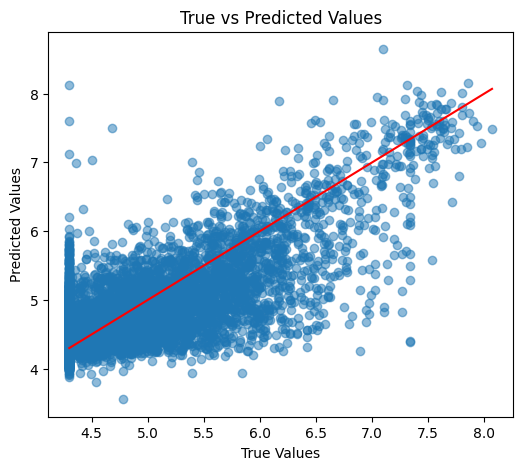

In [57]:
plt.figure(figsize=(6, 5))
plt.scatter(y_test, y_pred_test, alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red')
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("True vs Predicted Values")
plt.show()

#### Hyperparameter Optimization

In [58]:
def objective(trial):
    param = {
        "n_estimators": trial.suggest_int("n_estimators", 50, 500, step=50),
        "max_depth": trial.suggest_int("max_depth", 3, 20, step=1),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, step=0.01),
        "gamma": trial.suggest_float("gamma", 0, 5, step=0.1),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10, step=1),
    }
    model = xgb.XGBRegressor(**param, objective='reg:squarederror', random_state=42)
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring="r2")
    return scores.mean()

In [59]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

print("Best trial:")
print(f"  Best R² (CV): {study.best_trial.value:.4f}")
print(f"  Params: {study.best_trial.params}")

best_params = study.best_trial.params
best_model = xgb.XGBRegressor(**best_params, objective='reg:squarederror', random_state=42)
best_model.fit(X_train, y_train)

y_pred = best_model.predict(X_test)
test_r2 = r2_score(y_test, y_pred)
test_mse = mean_squared_error(y_test, y_pred)

print(f"\nTest R²: {test_r2:.4f}")
print(f"Test MSE: {test_mse:.4f}")

[I 2025-10-22 18:11:40,623] A new study created in memory with name: no-name-55316e4e-2dfd-4fe9-b7a2-4914f1430ed0
[I 2025-10-22 18:11:42,769] Trial 0 finished with value: 0.5441072668000431 and parameters: {'n_estimators': 400, 'max_depth': 20, 'learning_rate': 0.28, 'gamma': 3.6, 'min_child_weight': 10}. Best is trial 0 with value: 0.5441072668000431.
[I 2025-10-22 18:11:44,650] Trial 1 finished with value: 0.5266629526272519 and parameters: {'n_estimators': 350, 'max_depth': 7, 'learning_rate': 0.24000000000000002, 'gamma': 3.7, 'min_child_weight': 8}. Best is trial 0 with value: 0.5441072668000431.
[I 2025-10-22 18:11:47,553] Trial 2 finished with value: 0.554755849689158 and parameters: {'n_estimators': 500, 'max_depth': 16, 'learning_rate': 0.16, 'gamma': 3.1, 'min_child_weight': 1}. Best is trial 2 with value: 0.554755849689158.
[I 2025-10-22 18:11:50,176] Trial 3 finished with value: 0.5438956727458638 and parameters: {'n_estimators': 500, 'max_depth': 19, 'learning_rate': 0.25,

Best trial:
  Best R² (CV): 0.6102
  Params: {'n_estimators': 200, 'max_depth': 10, 'learning_rate': 0.060000000000000005, 'gamma': 0.1, 'min_child_weight': 3}

Test R²: 0.6191
Test MSE: 0.1643


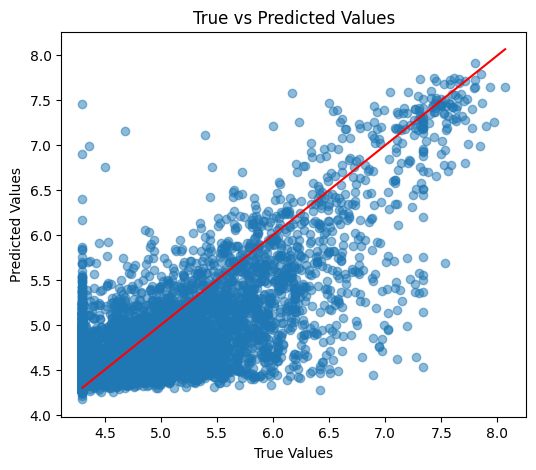

In [60]:
plt.figure(figsize=(6, 5))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red')
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("True vs Predicted Values")
plt.show()

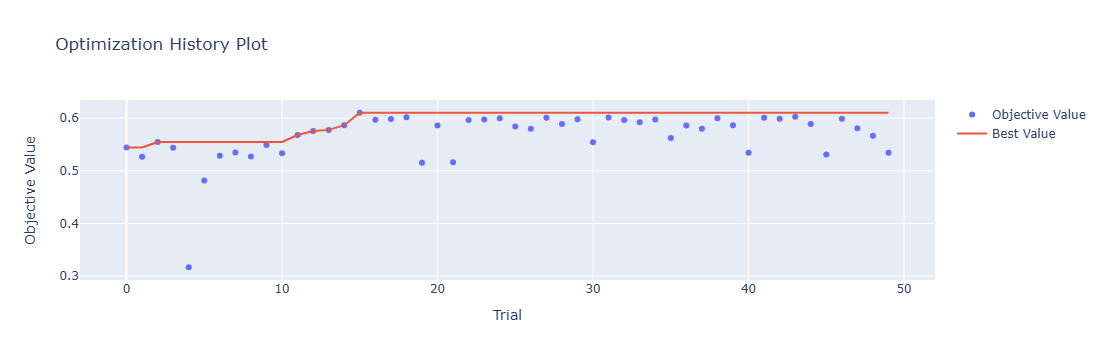

In [61]:
optuna.visualization.plot_optimization_history(study).show()

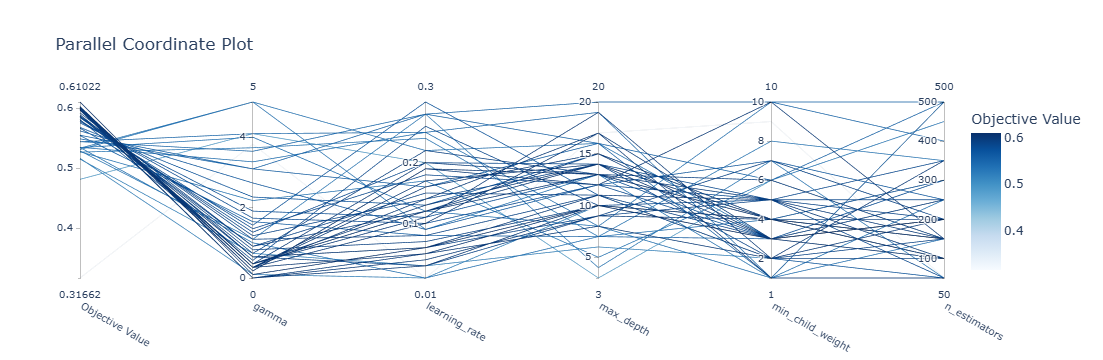

In [62]:
optuna.visualization.plot_parallel_coordinate(study).show()

#### SHAP

In [63]:
import shap

In [64]:
explainer = shap.Explainer(best_model)
shap_values = explainer(X_train)

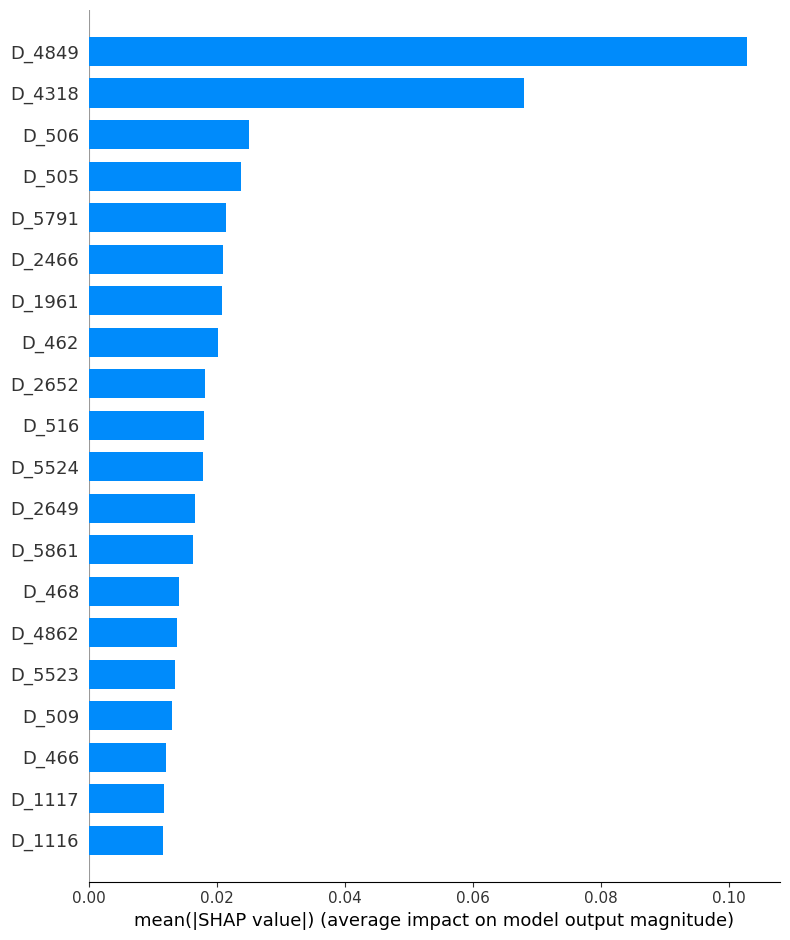

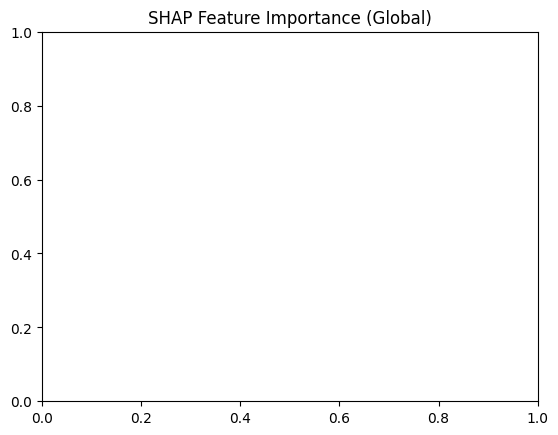

In [65]:
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_train, plot_type="bar")
plt.title("SHAP Feature Importance (Global)")
plt.show()

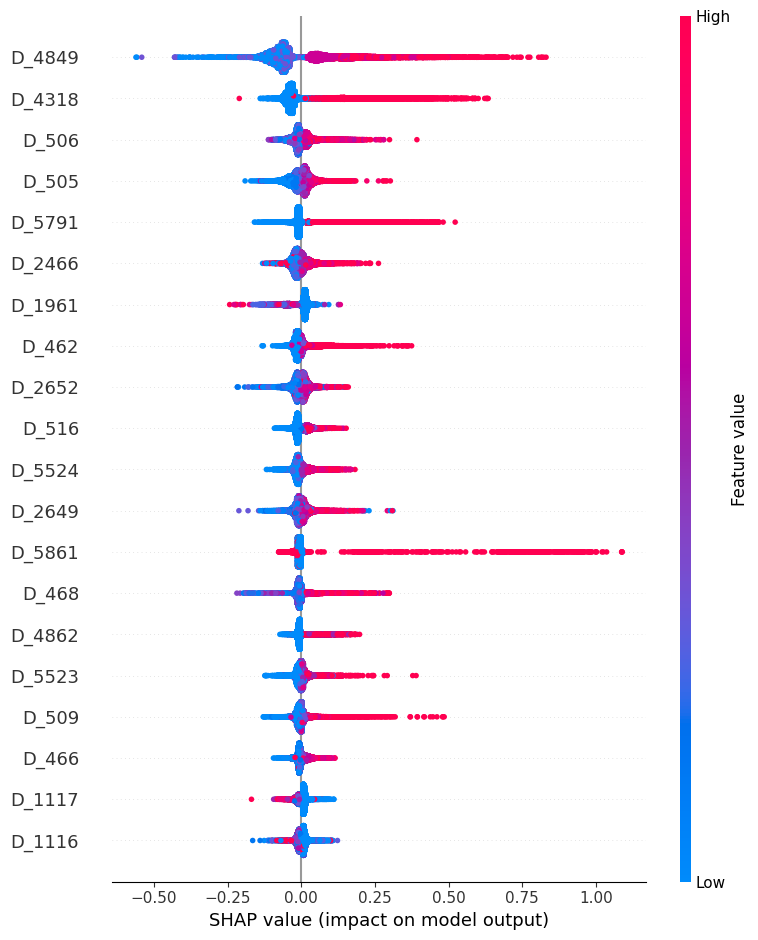

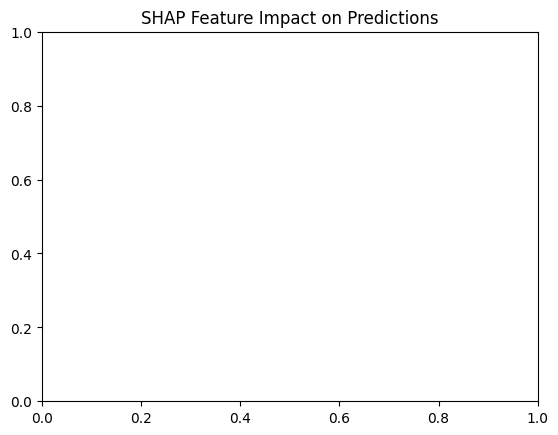

In [66]:
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_train)
plt.title("SHAP Feature Impact on Predictions")
plt.show()